In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2024-05-22 22:06:47.800608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 22:06:47.800670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 22:06:47.802176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# load data frames
df_train = pd.read_csv('/kaggle/input/dataframes-bal/train_bal.csv')
df_val = pd.read_csv('/kaggle/input/dataframes-bal/val_bal.csv')
df_test = pd.read_csv('/kaggle/input/dataframes-bal/test_bal.csv')

# load joint embeddings
#with open('/kaggle/input/j-embeds-bal/j_embeds_train (1).pkl', 'rb') as f:
    #v_embeds_train = pickle.load(f) 
    
with open('/kaggle/input/j-embeds-bal/j_embeds_val (1).pkl', 'rb') as f:
    j_embeds_val = pickle.load(f) 
    
with open('/kaggle/input/j-embeds-bal/j_embeds_test (2).pkl', 'rb') as f:
    j_embeds_test = pickle.load(f) 

In [3]:
print(len(j_embeds_test)) # Liste aus Tensors
print(j_embeds_test[0].shape)
print(type(j_embeds_test[0]))
print(j_embeds_test[0].device)

89
torch.Size([612, 768])
<class 'torch.Tensor'>
cuda:0


In [4]:
#load training embeddings one by one, foldername: j-embeds_bal_train-batches, and concatenate them
folder_path = "/kaggle/input/batch-train-j-features"
embedding_tensors = []

batches = 15
for i in range(batches): # number of batches of training joint embeddings
    file_path = os.path.join(folder_path, f'batch_{i+1}_v_features_test.pkl')  # Adjust the file naming convention as needed (made an error, should be called j_features since they are joint features)
    with open(file_path, 'rb') as f:
        j_embeds_batch = pickle.load(f) 
    embed_batch = torch.stack(j_embeds_batch, dim=0) # make a tensor out of the list of tensors
    embedding_tensors.append(embed_batch) # append tensor to the list of all training batch tensors


concatenated_tensor = torch.cat(embedding_tensors, dim=0) # concatenate tensors of tensor list
concatenated_tensor = concatenated_tensor.cpu().numpy() # push from cuda to cpu and convert to numpy array
print(concatenated_tensor.shape) # should be (len(training_df),612,768) # 300 worked!

(1500, 612, 768)


In [5]:
#X_train = torch.stack(j_embeds_test[:70], dim=0).cpu().numpy()
X_train = concatenated_tensor
#X_val = torch.stack(j_embeds_test[70:80], dim=0).cpu().numpy()
X_val = torch.stack(j_embeds_val, dim=0).cpu().numpy()
#X_test = torch.stack(j_embeds_test[80:89], dim=0).cpu().numpy()
X_test = torch.stack(j_embeds_test, dim=0).cpu().numpy()
print(X_train.shape, X_val.shape, X_test.shape)

(1500, 612, 768) (89, 612, 768) (89, 612, 768)


In [6]:
# convert labels to numerical values
label_encoder = LabelEncoder()
#labels = df_test['AUTHOR'].tolist()
#y_train = labels[:70]
#y_val = labels[70:80]
#y_test = labels[80:89]

split = batches*100

y_train = df_train['AUTHOR'].tolist()[:split]
#y_train = df_train['AUTHOR'].tolist()
y_val = df_val['AUTHOR'].tolist()
y_test = df_test['AUTHOR'].tolist()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print(y_test)

painter_mapping = list(label_encoder.classes_) # get new label numbers and painters (for confusion matrix legend)
print(painter_mapping)

[5 5 5 7 0 3 4 3 9 2 0 4 8 8 8 7 2 5 4 0 4 8 2 6 4 7 9 7 2 9 6 2 3 2 5 6 5
 1 0 8 8 7 3 9 4 1 1 0 1 4 5 4 8 3 0 5 8 0 8 5 1 9 5 3 1 1 5 2 7 3 8 6 4 0
 7 5 8 4 6 3 9 5 1 3 8 4 6 9 9]
['CRANACH, Lucas the Elder', 'GIOTTO di Bondone', 'GOGH, Vincent van', 'GRECO, El', 'REMBRANDT Harmenszoon van Rijn', 'RUBENS, Peter Paul', 'TIEPOLO, Giovanni Battista', 'TIZIANO Vecellio', 'UNKNOWN MASTER, Italian', 'VERONESE, Paolo']


In [7]:
# model architecture and configurations like the best model in classifier-visual-features-final.ipynb
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(612, 768)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

optim = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optim,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# train model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping]) # model needed more epochs than the others, 25...


# evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Epoch 1/25
 3/24 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.0599 - loss: 3.7562

I0000 00:00:1716415647.305326    3760 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716415647.320063    3760 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.1415 - loss: 3.2106

W0000 00:00:1716415654.345886    3760 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.1428 - loss: 3.2009 - val_accuracy: 0.2584 - val_loss: 7.0610
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.2744 - loss: 2.3147 - val_accuracy: 0.2584 - val_loss: 4.1748
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.3256 - loss: 2.1310 - val_accuracy: 0.2809 - val_loss: 2.8665
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3837 - loss: 1.8604 - val_accuracy: 0.2921 - val_loss: 2.0468
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4922 - loss: 1.5657 - val_accuracy: 0.3933 - val_loss: 1.9207
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5415 - loss: 1.3684 - val_accuracy: 0.5281 - val_loss: 1.4009
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5982 - loss: 1.1558 - val_accuracy: 0.5730 - val_loss: 1.4004
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6454 - loss: 1.0394 - val_accuracy: 0.5730 - val_loss: 

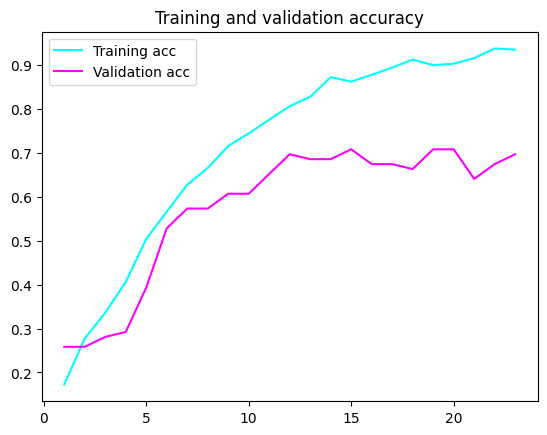

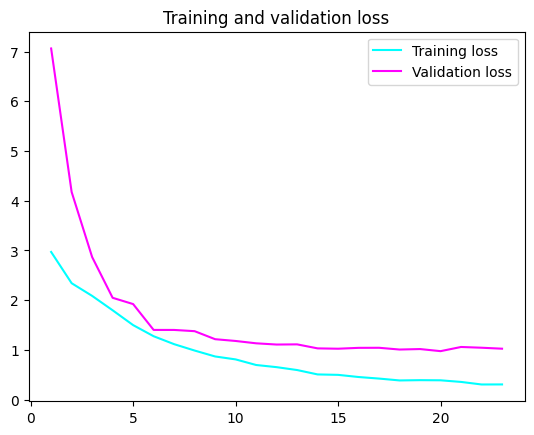

In [8]:
# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'magenta', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'magenta', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

W0000 00:00:1716415704.654311    3760 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


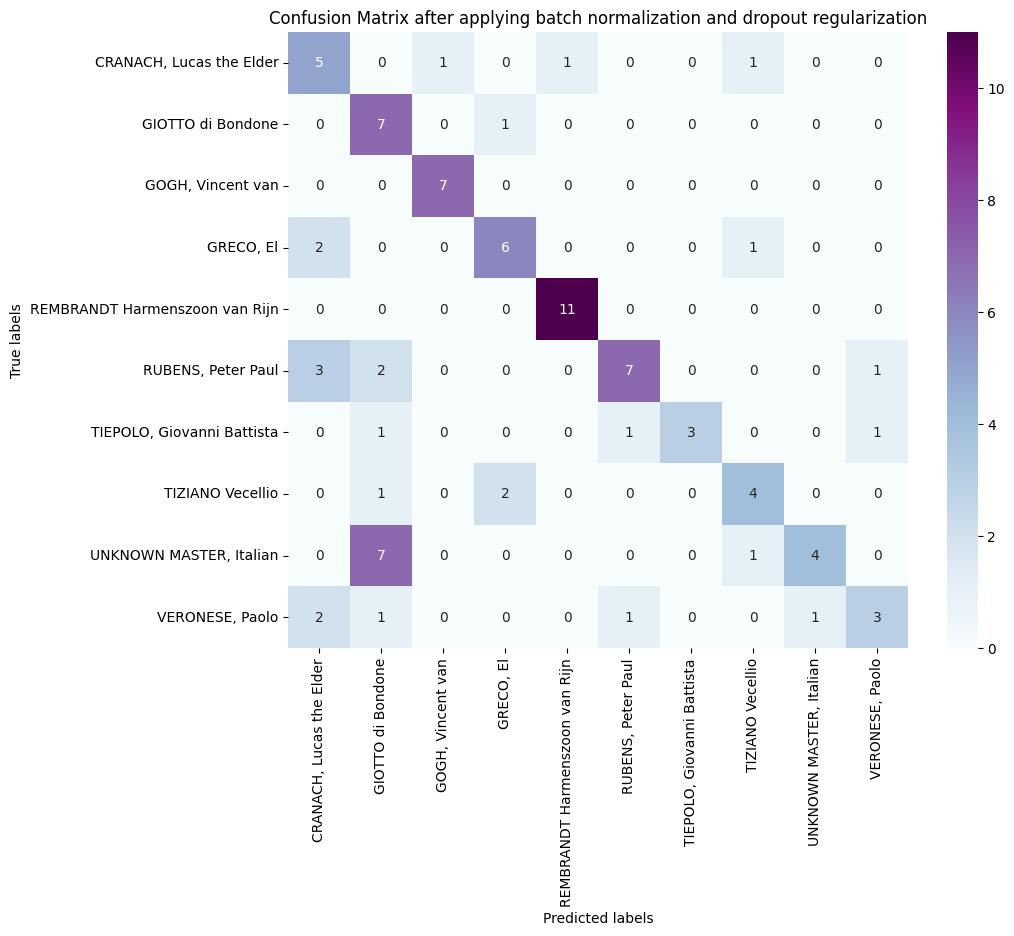

In [9]:
# confusion matrix after applying batch normalization and dropout regularization

# predictions on test set
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred_bool)

class_names = painter_mapping

# plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix after applying batch normalization and dropout regularization')
plt.show()